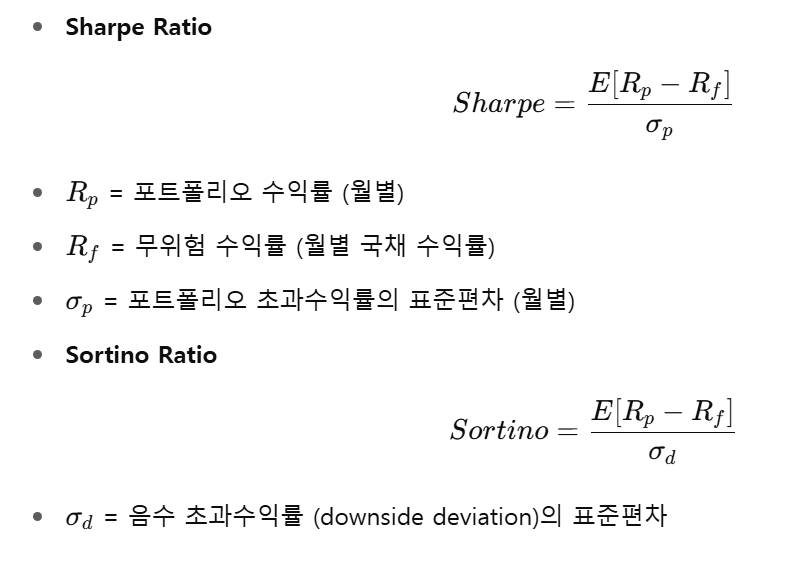

In [1]:
import pandas as pd
import numpy as np
import os
import yfinance as yf

def load_portfolio_returns(portfolio_file, monthly_return_folder):
    portfolios = pd.read_csv(portfolio_file)
    etfs = portfolios.columns.tolist()
    etfs.remove('Portfolio ID') 

    returns_list = []
    for etf in etfs:
        file_path = os.path.join(monthly_return_folder, f"{etf}_monthly_return.csv")
        df = pd.read_csv(file_path, parse_dates=['Date'])
        df.rename(columns={'Monthly Return': etf}, inplace=True)
        returns_list.append(df.set_index('Date'))

    returns_df = pd.concat(returns_list, axis=1)

    portfolio_returns = pd.DataFrame(index=returns_df.index)
    for idx, row in portfolios.iterrows():
        weights = row[1:]  # 'Portfolio ID' 제외한 비중
        portfolio_id = row['Portfolio ID']
        portfolio_returns[portfolio_id] = returns_df.mul(weights, axis=1).sum(axis=1)

    # 날짜를 컬럼으로 넣어 저장할 때 필요하므로 인덱스 리셋
    portfolio_returns = portfolio_returns.reset_index()
    return portfolio_returns

def download_and_clean_rf_rate(save_path="us_3m_treasury_rate_1998_2025_cleaned.csv"):
    ticker = "^IRX"
    start_date = "1998-02-01"
    end_date = "2025-05-31"

    irx = yf.Ticker(ticker)
    hist = irx.history(start=start_date, end=end_date)
    monthly_irx = hist['Close'].resample('ME').last() / 100  # % -> 소수 변환

    df_monthly_irx = monthly_irx.reset_index()
    df_monthly_irx.columns = ['Date', '3M_Treasury_Rate']

    # 시간대 제거
    df_monthly_irx['Date'] = pd.to_datetime(df_monthly_irx['Date'], utc=True)
    df_monthly_irx['Date'] = df_monthly_irx['Date'].dt.tz_convert(None)
    df_monthly_irx['Date'] = df_monthly_irx['Date'].dt.date

    df_monthly_irx.to_csv(save_path, index=False)
    print(f"무위험 수익률 데이터 저장 완료: {save_path}")
    return save_path

def calculate_ratios(portfolio_returns_file, rf_file, output_prefix):
    portfolio = pd.read_csv(portfolio_returns_file, parse_dates=['Date'])
    rf = pd.read_csv(rf_file)
    rf['Date'] = pd.to_datetime(rf['Date'], errors='coerce')

    if rf['Date'].dt.tz is not None:
        rf['Date'] = rf['Date'].dt.tz_localize(None)

    df = pd.merge(portfolio, rf, on='Date', how='inner')
    df['rf_monthly'] = df['3M_Treasury_Rate'] / 12

    portfolio_cols = [col for col in df.columns if col != 'Date' and col != '3M_Treasury_Rate' and col != 'rf_monthly']

    def sharpe_ratio(returns, rf_rate):
        mean_excess_return = (returns - rf_rate).mean()
        std_dev = (returns - rf_rate).std()
        if std_dev == 0:
            return np.nan
        return (mean_excess_return / std_dev) * np.sqrt(12)

    def sortino_ratio(returns, rf_rate):
        excess_returns = returns - rf_rate
        downside_std = excess_returns[excess_returns < 0].std()
        mean_excess_return = excess_returns.mean()
        if downside_std == 0:
            return np.nan
        return (mean_excess_return / downside_std) * np.sqrt(12)

    sharpe_list = []
    sortino_list = []

    for col in portfolio_cols:
        r = df[col]
        rf_rate = df['rf_monthly']
        sharpe_list.append(sharpe_ratio(r, rf_rate))
        sortino_list.append(sortino_ratio(r, rf_rate))

    results_df = pd.DataFrame({
        'Portfolio': portfolio_cols,
        'Sharpe Ratio': sharpe_list,
        'Sortino Ratio': sortino_list
    })

    results_df.to_csv(f'{output_prefix}_ratios.csv', index=False)
    print(f"{output_prefix}_ratios.csv 저장 완료")


if __name__ == "__main__":
    monthly_return_folder = 'monthly_return'

    # 1) 무위험 수익률 데이터 다운로드 및 저장 (처음 1회만 실행)
    rf_file = download_and_clean_rf_rate()

    # 2) portfolio 후보 처리
    folio_returns = load_portfolio_returns('portfolio_candidates04.csv', monthly_return_folder)
    folio_returns.to_csv('portfolio04_returns.csv', index=False, encoding='utf-8-sig')
    calculate_ratios('portfolio04_returns.csv', rf_file, 'portfolio04')

무위험 수익률 데이터 저장 완료: us_3m_treasury_rate_1998_2025_cleaned.csv
portfolio04_ratios.csv 저장 완료


In [2]:
import pandas as pd
import numpy as np

# CSV 파일 불러오기
folio_df = pd.read_csv('portfolio04_returns.csv', parse_dates=['Date'])

# Date 컬럼 제외한 포트폴리오 컬럼 리스트
portfolios04 = [col for col in folio_df.columns if col != 'Date']

def calc_annualized_metrics(df, portfolios):
    T = len(df)  # 전체 월 개수
    results = []

    for p in portfolios:
        returns = df[p].values

        # 연환산 수익률 계산
        total_return = np.prod(1 + returns)
        ann_return = total_return ** (12 / T) - 1

        # 연환산 변동성 계산 (월별 표준편차 * sqrt(12))
        ann_volatility = np.std(returns, ddof=1) * np.sqrt(12)

        results.append({
            'Portfolio': p,
            'Annualized Return': ann_return,
            'Annualized Volatility': ann_volatility
        })

    return pd.DataFrame(results)

# 포트폴리오 연 수익률, 변동성
folio04_metrics = calc_annualized_metrics(folio_df, portfolios04)

print("Portfolio04 Metrics:")
print(folio04_metrics.head())

# 필요시 CSV 저장
folio04_metrics.to_csv('portfolio04_annual_metrics.csv', index=False)

Portfolio04 Metrics:
  Portfolio  Annualized Return  Annualized Volatility
0         1           0.084756               0.120519
1         2           0.094490               0.159112
2         3           0.086807               0.119213
3         4           0.090781               0.131366
4         5           0.092119               0.169726


In [3]:
import pandas as pd
import numpy as np

# 1. 연 수익률, 변동성 계산 함수 (앞에서 작성한 함수)
def calc_annualized_metrics(df, portfolios):
    T = len(df)  # 전체 월 개수
    results = []

    for p in portfolios:
        returns = df[p].values
        total_return = np.prod(1 + returns)
        ann_return = total_return ** (12 / T) - 1
        ann_volatility = np.std(returns, ddof=1) * np.sqrt(12)

        results.append({
            'Portfolio': p,
            'Annualized Return': ann_return,
            'Annualized Volatility': ann_volatility
        })

    return pd.DataFrame(results)

# 2. CSV 불러오기
folio_df = pd.read_csv('portfolio04_returns.csv', parse_dates=['Date'])
folio_ratios = pd.read_csv('portfolio04_ratios.csv')

# 3. 포트폴리오 리스트
portfolios04 = [col for col in folio_df.columns if col != 'Date']

# 4. 연 수익률, 변동성 계산
folio_metrics = calc_annualized_metrics(folio_df, portfolios04)

# Portfolio 컬럼을 모두 문자열(str)로 변환
folio_metrics['Portfolio'] = folio_metrics['Portfolio'].astype(str)
folio_ratios['Portfolio'] = folio_ratios['Portfolio'].astype(str)

# 5. ratios 데이터와 병합 (Portfolio 기준)
folio_full = pd.merge(folio_metrics, folio_ratios, on='Portfolio', how='left')

# 6. 결과 확인
print("Portfolio04 Combined Metrics:")
print(folio_full.head())

# 7. 파일 저장
folio_full.to_csv('portfolio04_full_metrics.csv', index=False)

Portfolio04 Combined Metrics:
  Portfolio  Annualized Return  Annualized Volatility  Sharpe Ratio  \
0         1           0.084756               0.120519      0.568115   
1         2           0.094490               0.159112      0.521496   
2         3           0.086807               0.119213      0.590347   
3         4           0.090781               0.131366      0.574818   
4         5           0.092119               0.169726      0.486236   

   Sortino Ratio  
0       0.821024  
1       0.721285  
2       0.839590  
3       0.870821  
4       0.663691  


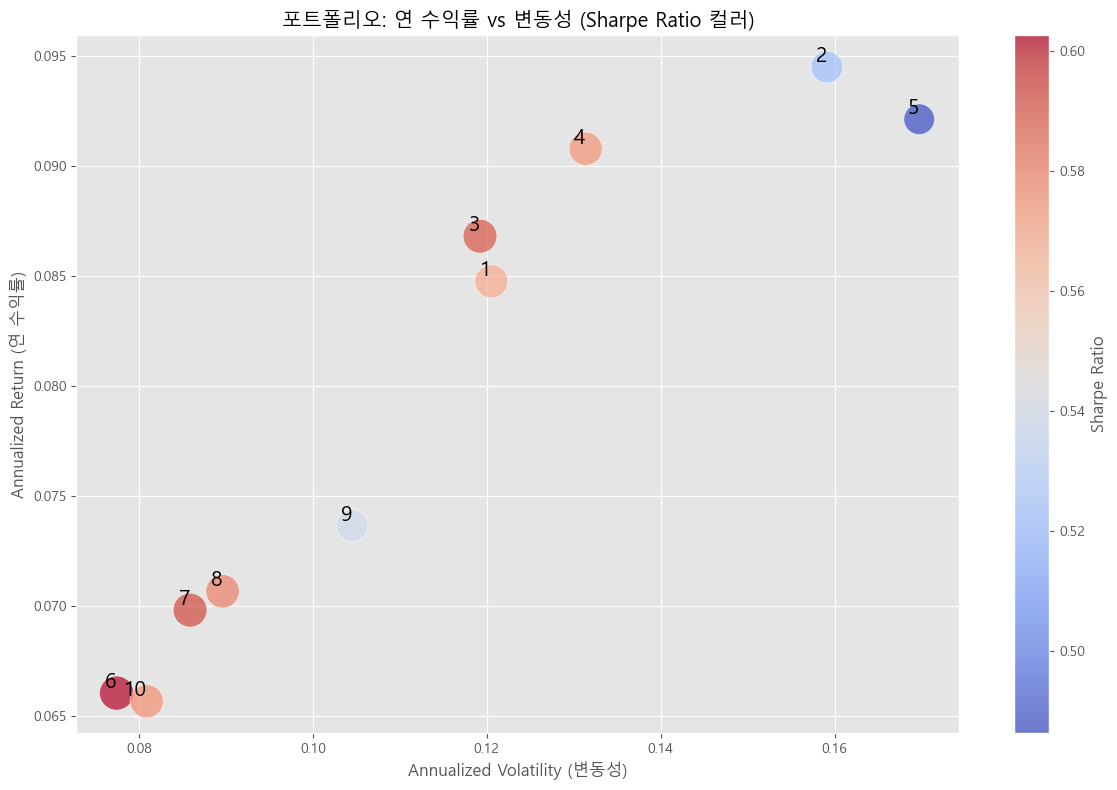

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# CSV 파일 불러오기
folio_df = pd.read_csv('portfolio04_full_metrics.csv')

# 스타일 설정
plt.style.use('ggplot')

# 버블 크기 조정
folio_df['BubbleSize'] = folio_df['Sharpe Ratio'] * 1000

# 차트 크기
plt.figure(figsize=(12, 8))

# 버블 색상을 Sharpe Ratio로 매핑
scatter = plt.scatter(
    folio_df['Annualized Volatility'],
    folio_df['Annualized Return'],
    s=folio_df['BubbleSize'],
    c=folio_df['Sharpe Ratio'],             # Sharpe Ratio 컬러 매핑
    cmap='coolwarm',                        # 컬러맵: coolwarm (다른 예: viridis, plasma, inferno)
    alpha=0.7,
    edgecolors='white',
    linewidth=0.5
)

# 컬러바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# 포트폴리오 이름 텍스트 추가
for _, row in folio_df.iterrows():
    plt.text(
        row['Annualized Volatility'],
        row['Annualized Return'],
        str(int(float(row['Portfolio']))),  # 숫자형 포트폴리오 이름 정수형으로 표현
        fontsize=15,
        color='black',
        ha='right',
        va='bottom'
    )

# 축 및 제목
plt.xlabel('Annualized Volatility (변동성)')
plt.ylabel('Annualized Return (연 수익률)')
plt.title('포트폴리오: 연 수익률 vs 변동성 (Sharpe Ratio 컬러)')

# 그리드 및 레이아웃
plt.grid(True)
plt.tight_layout()
plt.show()

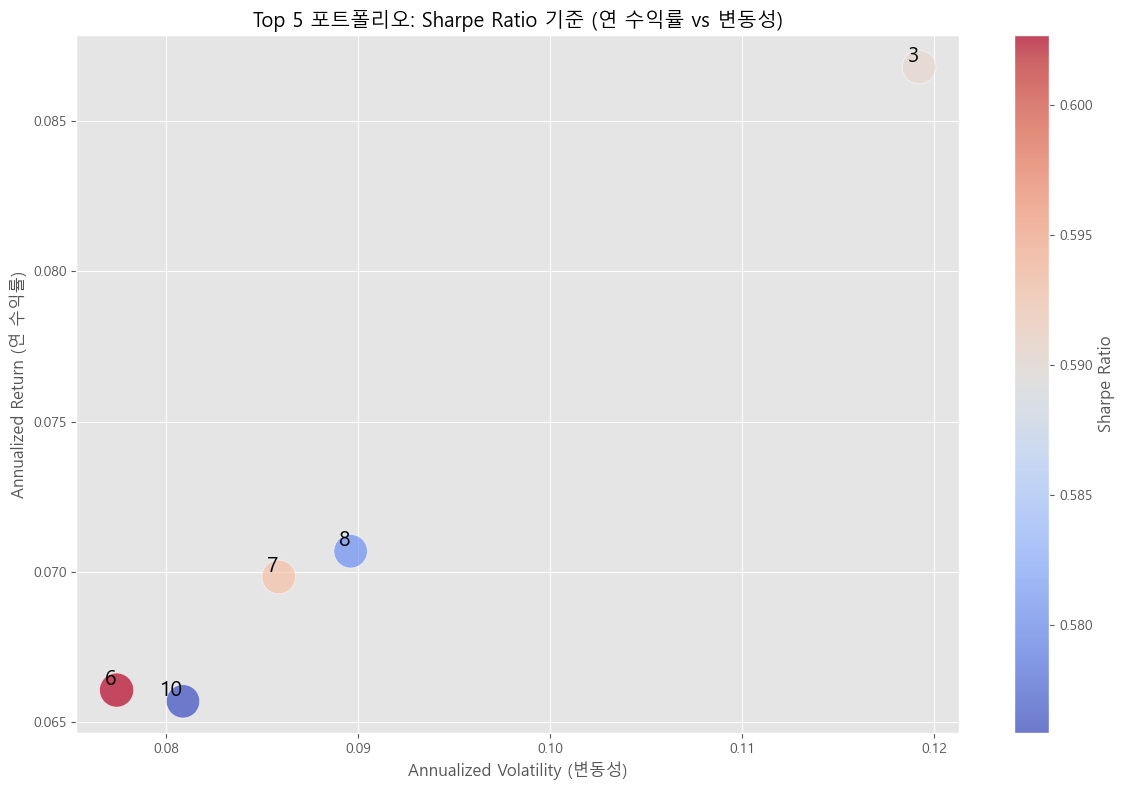

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# CSV 파일 불러오기
folio_df = pd.read_csv('portfolio04_full_metrics.csv')

# Sharpe Ratio 기준 Top5 포트폴리오만 추출
top5_df = folio_df.sort_values(by='Sharpe Ratio', ascending=False).head(5).copy()

# 버블 크기 조정
top5_df['BubbleSize'] = top5_df['Sharpe Ratio'] * 1000

# 스타일 설정
plt.style.use('ggplot')

# 차트 크기
plt.figure(figsize=(12, 8))

# 버블 색상을 Sharpe Ratio로 매핑
scatter = plt.scatter(
    top5_df['Annualized Volatility'],
    top5_df['Annualized Return'],
    s=top5_df['BubbleSize'],
    c=top5_df['Sharpe Ratio'],
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='white',
    linewidth=0.5
)

# 컬러바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# 포트폴리오 이름 텍스트 추가
for _, row in top5_df.iterrows():
    plt.text(
        row['Annualized Volatility'],
        row['Annualized Return'],
        str(int(float(row['Portfolio']))),  # 정수형 포트폴리오 이름
        fontsize=15,
        color='black',
        ha='right',
        va='bottom'
    )

# 축 및 제목
plt.xlabel('Annualized Volatility (변동성)')
plt.ylabel('Annualized Return (연 수익률)')
plt.title('Top 5 포트폴리오: Sharpe Ratio 기준 (연 수익률 vs 변동성)')

# 그리드 및 레이아웃
plt.grid(True)
plt.tight_layout()
plt.show()